# Загрузка и подготовка набора данных

In [51]:
import sqlalchemy as sa
from sqlalchemy.engine import make_url
import getpass
import numpy as np
import pandas as pd
import os
import tempfile
import psycopg2
from sklearn.cluster import KMeans

#для работы с датами
import datetime as dt
from datetime import datetime as dte
from datetime import date
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import *
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [52]:
def load_from_gp(login, password, query_name='rfm', **kwargs):
    from datetime import datetime
    import time
    sql_path = 'sql/'

    with open(
        f"{sql_path}{query_name}_prep.sql", "r", encoding="utf-8"
    ) as file:
        prep_query = file.read().format(**kwargs)
    with open(
        f"{sql_path}{query_name}_main.sql", "r", encoding="utf-8"
    ) as file:
        main_query = file.read().format(**kwargs)
    with open(
        f"{sql_path}{query_name}_close.sql", "r", encoding="utf-8"
    ) as file:
        close_query = file.read().format(**kwargs)

    connection_url = "postgresql://{}:{}@gp.data.lmru.tech:5432/adb".format(
        login, password
    )
    with psycopg2.connect(connection_url) as conn:
        cur = conn.cursor()
        st = datetime.now()
        cur.execute(prep_query)
        print(f'Preparation query time: {datetime.now() - st}')
        with tempfile.TemporaryFile() as tmpfile:
            head = "HEADER"
            st = datetime.now()
            copy_sql = f"COPY ({main_query}) TO STDOUT WITH CSV {head}"
            print(f'Main query time: {datetime.now() - st}')
            cur.copy_expert(copy_sql, tmpfile)
            tmpfile.seek(0)
            _df = pd.read_csv(tmpfile)
        conn.commit()
        st = datetime.now()
        cur.execute(close_query)
        print(f'Closing query time: {datetime.now() - st}')
        cur.close()
    return _df

In [54]:
df_old = load_from_gp('60208373', 'MYdoggym2001', 'rfm', calculation_date='2023-08-01')
df_old.to_csv('df_segmentation_profi_with_12_months_delay.csv')

set gp_workfile_limit_per_query='10000MB';

CREATE TEMP TABLE temp_sales
(max_purch_date date,
calc_date date,
"period" varchar(10),
card_no varchar(36),
client_subtype smallint,
district varchar(36),
store_id smallint,
margin numeric,
wo_nds numeric,
turnover numeric)
distributed BY (card_no);

CREATE TEMP TABLE temp_client_numbers
(client_number varchar(36),
card_no varchar(36))
distributed BY (card_no);

CREATE TEMP TABLE temp_cohort
(client_number varchar(36),
first_date date)
distributed BY (client_number);

CREATE TEMP TABLE temp_last_district
(client_number varchar(36),
district varchar(36),
store_id smallint)
distributed BY (client_number);

----Выгрузка данных по продажам
INSERT INTO temp_sales(max_purch_date
    , calc_date
    , "period"
    , card_no
    , client_subtype
    , district
    , store_id
    , margin
    , wo_nds
    , turnover)
SELECT max(t1.purch_date) as max_purch_date
    , t1.calc_date
    , t1."period"
    , t1.card_no
    , max(t1.client_subtype) as clie

In [53]:
df = load_from_gp('60208373', 'MYdoggym2001', 'rfm', calculation_date='2024-08-01')
df.to_csv('df_segmentation_profi.csv')

set gp_workfile_limit_per_query='10000MB';

CREATE TEMP TABLE temp_sales
(max_purch_date date,
calc_date date,
"period" varchar(10),
card_no varchar(36),
client_subtype smallint,
district varchar(36),
store_id smallint,
margin numeric,
wo_nds numeric,
turnover numeric)
distributed BY (card_no);

CREATE TEMP TABLE temp_client_numbers
(client_number varchar(36),
card_no varchar(36))
distributed BY (card_no);

CREATE TEMP TABLE temp_cohort
(client_number varchar(36),
first_date date)
distributed BY (client_number);

CREATE TEMP TABLE temp_last_district
(client_number varchar(36),
district varchar(36),
store_id smallint)
distributed BY (client_number);

----Выгрузка данных по продажам
INSERT INTO temp_sales(max_purch_date
    , calc_date
    , "period"
    , card_no
    , client_subtype
    , district
    , store_id
    , margin
    , wo_nds
    , turnover)
SELECT max(t1.purch_date) as max_purch_date
    , t1.calc_date
    , t1."period"
    , t1.card_no
    , max(t1.client_subtype) as clie

In [ ]:
# получение логина/пароля учетной записи в GP

with open('creds.txt', 'r') as file:
    user_, password_ = file.read().split('\n')
user_

In [ ]:
# Подключение к GreenPlum
conn = psycopg2.connect(
    host='gp.data.lmru.tech',
    dbname='adb',
    user= user_,
    password= password_,
    port='5432',
)

engine_gp = sa.create_engine("postgresql://{}:{}@gp.data.lmru.tech:5432/adb".format(user_, password_))
connection_url = "postgresql://{}:{}@gp.data.lmru.tech:5432/adb".format(user_, password_)

In [ ]:
# сохранение дат в формате год-месяц-день
startDate = '2021-10-01'

In [ ]:
# Цвета для сегментов
color_map = {
    'new': '#9CCC65',
    'renew': '#9CAA99',
    'churned': '#795548',
    'at_risk': '#FF5722',
    'good': '#FDD835',
    'active': '#1565C0'}

In [ ]:
# Функция для выгрузки данных
def read_sql_tmpfile(query, cur):
    with tempfile.TemporaryFile() as tmpfile:
        head="HEADER"
        copy_sql = f"COPY ({query}) TO STDOUT WITH CSV {head}"
        dtype = {'card_no':object, 'client_number':object}
        cur.copy_expert(copy_sql, tmpfile)
        tmpfile.seek(0)
        df = pd.read_csv(tmpfile, dtype=dtype, parse_dates=['purch_date', 'purch_month', 'first_month'],low_memory=False)
        return df

## Получение данных из песочницы с картами лояльности и первой датой покупки и из чеков

In [ ]:
# prep_query = f""" 
# set gp_workfile_limit_per_query='10000MB';

# CREATE TEMP TABLE temp_sales
# (purch_date date,
# purch_month date,
# first_month date,
# client_id varchar(100),
# card_no varchar(100),
# turnover numeric,
# qty_positive smallint)
# distributed BY (client_id);

# CREATE TEMP TABLE temp_first_date
# (client_id varchar(100),
# card_no varchar(100),
# first_month date)
# distributed BY (client_id);

# ----Выгрузка первых дат покупки из песочницы
# INSERT INTO temp_first_date(client_id
#     , card_no
#     , first_month)
# select fpt.client_mapping_key as client_id
#     , fpt.card_num as card_no
#     , date_trunc('month', fpt.first_purch_1p)::date as first_month
# from sandbox_datamng_testdq.first_purch_ttl fpt 
# where fpt.client_subtype = 'PROFI'
# and fpt.card_num is not null;

# ----Выгрузка данных по продажам
# INSERT INTO temp_sales(purch_date
#     , purch_month
#     , first_month
#     , client_id
#     , card_no
#     , turnover
#     , qty_positive)
# SELECT CASE 
#         WHEN t1.qty_positive = 1 
#         THEN t1.purch_date 
#         ELSE NULL 
#     END AS purch_date --для подсчета уникальных дней (только покупки)
#     , CASE 
#         WHEN t1.qty_positive = 1 
#         THEN t1.purch_month
#         ELSE NULL 
#     END AS purch_month --месяцы с покупками
#     ,t1.first_month
#     ,t1.client_id
#     ,t1.card_no
#     ,sum(CASE 
#             WHEN t1.line_item_type='Normal' 
#             THEN t1.line_turnover 
#             ELSE 0 
#         END) AS turnover  --ТО с учетом возвратов, без услуг
#     ,t1.qty_positive
# FROM (
#     SELECT
#         rec.opened_date::date as purch_date
#         ,date_trunc('month', rec.opened_date)::date AS purch_month
#         ,tfd.first_month
#         ,tfd.client_id
#         ,rec.client_loyalty_card_number as card_no
#         ,COALESCE(rec.line_turnover, 0) AS line_turnover
#         ,CASE WHEN coalesce(rec.line_quantity,0) > 0 THEN 1 ELSE 0 END AS qty_positive
#         ,rec.line_item_type
#     FROM  
#         dds.v_receipt_lines_sensitive rec
#     LEFT JOIN temp_first_date tfd
#     ON rec.client_loyalty_card_number = tfd.card_no
#     WHERE 
#         rec.line_type IN ('Sales', 'pickedUp orders', 'Returns')
#         AND rec.client_loyalty_card_number IS NOT NULL
#         AND rec.opened_date >= '{startDate}'::date 
#         AND rec.opened_date < date_trunc('month', now())::date
#         AND rec.client_subtype = 'Professional Card'
# ) t1
# group by t1.purch_date
#     ,t1.purch_month
#     ,t1.first_month
#     ,t1.client_id
#     ,t1.card_no
#     ,t1.qty_positive;
# """

# close_query = """    
# DROP TABLE IF EXISTS temp_sales;
# DROP TABLE IF EXISTS temp_first_date;
# """

# query_sales = """
# SELECT ts.purch_date
#     , ts.purch_month
#     , ts.first_month
#     , ts.client_id
#     , ts.card_no
#     , ts.turnover
#     , ts.qty_positive
# FROM temp_sales ts
# order by ts.purch_date
# """

In [ ]:
prep_query = f""" 
set gp_workfile_limit_per_query='10000MB';

CREATE TEMP TABLE temp_sales
(purch_date date,
purch_month date,
card_no varchar(36),
turnover numeric,
qty_positive smallint)
distributed BY (card_no);

CREATE TEMP TABLE temp_cohort
(first_month date,
card_no varchar(36))
distributed BY (card_no);

CREATE TEMP TABLE temp_client_numbers
(client_number varchar(36),
card_no varchar(36))
distributed BY (card_no);

----Выгрузка данных по продажам
INSERT INTO temp_sales(purch_date
    , purch_month
    , card_no
    , turnover
    , qty_positive)
SELECT CASE
        WHEN t1.qty_positive = 1 
        THEN t1.purch_date 
        ELSE NULL 
    END AS purch_date --для подсчета уникальных дней (только покупки)
    , CASE 
        WHEN t1.qty_positive = 1 
        THEN t1.purch_month
        ELSE NULL 
    END AS purch_month --месяцы с покупками
    , t1.card_no
    , sum(CASE 
            WHEN t1.line_item_type='Normal' 
            THEN t1.line_turnover 
            ELSE 0 
        END) AS turnover  --ТО с учетом возвратов, без услуг
    , t1.qty_positive
FROM (
    SELECT
        rec.opened_date::date as purch_date
        ,date_trunc('month', rec.opened_date)::date AS purch_month
        ,rec.client_loyalty_card_number as card_no
        ,COALESCE(rec.line_turnover, 0) AS line_turnover
        ,CASE WHEN coalesce(rec.line_quantity,0) > 0 THEN 1 ELSE 0 END AS qty_positive
        ,rec.line_item_type
    FROM  
        dds.v_receipt_lines_sensitive rec
    WHERE 
        rec.line_type IN ('Sales', 'pickedUp orders', 'Returns')
        AND rec.client_loyalty_card_number IS NOT NULL
        AND rec.opened_date >= '{startDate}'::date
        AND rec.opened_date < date_trunc('month', now())::date -- calc_date
        AND rec.client_subtype = 'Professional Card'
) t1
group by t1.purch_date
    ,t1.purch_month
    ,t1.card_no
    ,t1.qty_positive;


----Выгрузка первой даты покупки по номеру сервисной карты
INSERT INTO temp_cohort(first_month
    , card_no)
SELECT date_trunc('month', t2.opened_date)::date as first_month
    , t2.card_no
FROM (
    SELECT rec.client_loyalty_card_number as card_no
        , rec.opened_date
        , row_number() over(
            partition by rec.client_loyalty_card_number 
            order by rec.opened_date) as rn
    FROM dds.v_receipt_lines_sensitive rec
    where rec.client_subtype = 'Professional Card'
    and line_type in ('Sales', 'pickedUp orders', 'Returns')
    and rec.client_loyalty_card_number in (select distinct card_no from temp_sales)
) t2
where rn = 1;


----Получение client_numbers из LYS по номеру сервисной карты
INSERT INTO temp_client_numbers(client_number
    , card_no)
select customer as client_number
    , "number" as card_no
from 
    (select t2.accountid
        , t2.customer
        , t2."number"
        , t2.validitystartdate as validity_date
        , ROW_NUMBER() OVER(PARTITION BY t2.number::varchar ORDER BY t2.validitystartdate desc) AS rn 
    from lysloyalty_ods.v_account t1  
    inner join ( 
        SELECT vs.accountid
            , vs.customer
            , vs."number"
            , vs.validitystartdate 
        FROM lysloyalty_ods.v_support vs
        UNION ALL 
        SELECT vcs.accountid
            , vcs.customer
            , vcs."number"
            , vcs.validitystartdate
        FROM lysloyalty_ods.v_cleared_support vcs) t2
        on t1.id = t2.accountid
    ) t 
    where t.rn = 1
    and t."number" in (select distinct card_no from temp_sales);
"""

close_query = """    
DROP TABLE IF EXISTS temp_sales;
DROP TABLE IF EXISTS temp_cohort;
DROP TABLE IF EXISTS temp_client_numbers;
"""

query_sales = """
SELECT ts.purch_date
    , ts.purch_month
    , tc.first_month
    , ts.card_no
    , COALESCE(tcs.client_number, 'ca_'||ts.card_no) AS client_number
    , ts.turnover
    , ts.qty_positive
FROM temp_sales ts
LEFT JOIN temp_cohort tc ON tc.card_no = ts.card_no
LEFT JOIN temp_client_numbers tcs ON tcs.card_no = ts.card_no
order by ts.purch_date
"""

In [ ]:
#### Выгрузка запросов
start_time = dte.now()
print('Start time: {}'.format(start_time))

with psycopg2.connect(connection_url) as conn:
    cur = conn.cursor()
    cur.execute(prep_query)
    tr_time = dte.now()
    print('Data Load duration: {}'.format(tr_time - start_time))
    df_sales = read_sql_tmpfile(query_sales, cur)
    cur.execute(close_query)
    conn.commit()

end_time = dte.now()
print('Data Load duration: {}'.format(end_time - start_time))

In [ ]:
df_sales.head()

In [ ]:
df_sales.info()

In [ ]:
df_sales.nunique()

In [ ]:
df_sales.isna().mean()

In [ ]:
def calc(x):
    s_dates = np.sort(x.purch_date.values)
    s, c = 0, 0
    mi, ma = 10_000, -1
    for i, d in enumerate(s_dates):
        if i != 0:
            val = (d - s_dates[i - 1]).astype('timedelta64[D]') / np.timedelta64(1, 'D')
            if val > ma:
                ma = val
            if val < mi:
                mi = val
            s += val
            c += 1
    mean_date_diff = s / c if c != 0 else -1
    mean_turnover = x.turnover.mean()
    card_numbers = x.card_no.nunique()
    f_month = x.first_month.min()
    return f_month, c + 1, mi if c != 0 else -1, ma, mean_date_diff, mean_turnover, card_numbers


In [ ]:
grouped_by_client = pd.DataFrame()
grouped_by_client = df_sales[df_sales['qty_positive'] != 0].groupby(by=['client_number']).apply(calc)
grouped_by_client = pd.DataFrame.from_dict(dict(zip(grouped_by_client.index, grouped_by_client.values))).T
grouped_by_client.columns = ['first_month', 'count', 'min_diff', 'max_diff', 'mean_diff', 'mean_turnover', 'count_cards']
grouped_by_client

In [ ]:
grouped_by_client.to_csv('grouped_clients.csv')

In [ ]:
df_sales.to_csv('df_sales_profi.csv', index=False)

# Загрузка из локального хранилища

In [1]:
import sqlalchemy as sa
from sqlalchemy.engine import make_url
import getpass
import numpy as np
import pandas as pd
import os
import tempfile
import psycopg2
from sklearn.cluster import KMeans

#для работы с датами
import datetime as dt
from datetime import datetime as dte
from datetime import date
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import *
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_sales = pd.read_csv('df_sales_profi.csv')

In [3]:
# Исключим возвраты
df_sales_wo_returns = df_sales[df_sales.qty_positive == 1]
df_sales_wo_returns.head()

,purch_date,purch_month,first_month,card_no,client_number,turnover,qty_positive
0,2021-10-01,2021-10-01,2021-05-01,93010093020600100,21026935,1345.00,1
1,2021-10-01,2021-10-01,2019-09-01,93010093991172600,11081032,6431.00,1
2,2021-10-01,2021-10-01,2020-10-01,93010093001046976,17906240,6046.00,1
3,2021-10-01,2021-10-01,2021-03-01,93010093994033957,20110139,1654.56,1
4,2021-10-01,2021-10-01,2020-11-01,93010093992518744,5394327,6373.00,1


In [4]:
df_sales['purch_date'] = pd.to_datetime(df_sales['purch_date'])
df_sales['purch_month'] = pd.to_datetime(df_sales['purch_month'])
df_sales['first_month'] = pd.to_datetime(df_sales['first_month'])
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28268135 entries, 0 to 28268134
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   purch_date     datetime64[ns]
 1   purch_month    datetime64[ns]
 2   first_month    datetime64[ns]
 3   card_no        int64         
 4   client_number  object        
 5   turnover       float64       
 6   qty_positive   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(1)
memory usage: 1.5+ GB


In [5]:
grouped_by_client = pd.read_csv('grouped_clients.csv')

# Анализ

## Разделить по периодам (7 дней, 8 дней, ... 30 дней) и посмотреть зависимость среднего количества вернувшихся за повторными покупками клиентов. (Количество дней между покупками, если это количество дней не больше 7, 8, ... 30 дней для каждого клиента)

In [ ]:
df_sales['since_last_purch'] = df_sales.groupby('client_number')['purch_date'].diff().dt.days
df_sales
# df_sales['date_diff'] = 

In [ ]:
df_sales_with_date_diffs = df_sales.sort_values(by=['client_number', 'purch_date'])

In [ ]:
df_sales_with_date_diffs

In [ ]:
def plot(df_sales_with_date_diffs):
    out = {}
    a = np.histogram(df_sales_with_date_diffs.since_last_purch, bins=[i for i in range(35 + 2)])
    thresholds = range(1, 36)
    bs = []
    for t in thresholds:
        b = a[0][np.where(a[1] <= t)]
        b = [i / np.sum(b) for i in b]
        bs.append(b)

    ans = {}
    for t in [0] + list(thresholds):
        for b in bs:
            if len(b) > t:
                if t not in ans:
                    ans[t] = []
                ans[t].append(b[t])

    # fig, axs = plt.subplots(1, 1, figsize=(25, 15))
    for cnt in ans.keys():
        weights = ans[cnt]
        begin = cnt - 1
        bins = [begin + i for i in range(len(weights))]
        # axs.plot(bins, weights, label=f"{begin + 1} (период, дней)", linewidth=2.0, linestyle='--')
        out[cnt] = (bins, weights)

    # axs.set_xticks(np.arange(0, 36, 1))
    # axs.set_yticks(np.arange(0, 1, 0.05))
    # axs.grid(visible=True, linestyle=':', linewidth=1.3)
    # axs.set_xlabel("Верхняя граница количества дней между покупками")
    # axs.set_ylabel("Относительное количество случаев")
    # fig.legend()
    # fig.tight_layout()
    return out

plot(df_sales_with_date_diffs)

Можно принять, что в период от 0 до 15 дней обычно совершается повторная покупка от профи-клиента, т.к. последующее увеличение границы не приводит к значительному изменению производных относительных количеств (отношений) случаев различной периодичности (доля случаев с периодом в 1 день не изменяется относительно доли случаев с периодом в 2, 3 ... дней).
При дальнейшем расширении интервала могут учитываться следующие "проекты" профи-клиента, что некорректно.

Анализ на подобие "метода локтя".

Посмотреть, меняется ли это по датам (январь 2021 - июнь 2024). Возможно, построить трехмерный график

In [ ]:
# from datetime import datetime, timedelta
from tqdm.notebook import tqdm
dates = np.sort(df_sales_with_date_diffs['purch_date'].unique())
date_iter = pd.date_range(dates[0], dates[-2], freq='10D')

def date_plus(d, t=30):
    return d + np.timedelta64(30, 'D')


outs = {}
for d_s in tqdm(date_iter):
    d_e = date_plus(d_s)
    df_small = df_sales_with_date_diffs[df_sales_with_date_diffs['purch_date'] >= d_s][df_sales_with_date_diffs['purch_date'] <= d_e]
    out = plot(df_small)
    outs[d_s] = out

outs



In [ ]:
fig = go.Figure()

# Преобразование данных
dates = list(outs.keys())
z_indices = [pd.to_datetime(date).timestamp() for date in dates]

for date, z in zip(dates, z_indices):
    series = outs[date]
    for index, (x_values, y_values) in series.items():
        z_values = np.full(len(x_values), z)
        fig.add_trace(go.Scatter3d(x=x_values, y=y_values, z=z_values, mode='lines', name=f'{date} - Line {index}'))

# Обновление макета графика
fig.update_layout(
    width=1 200,
    height=800,
    scene=dict(
        xaxis_title='Верхняя граница количества дней между покупками',
        yaxis_title='Относительное количество случаев',
        zaxis_title='Дата начала периода рассмотрения',
        zaxis=dict(
            tickvals=z_indices,
            ticktext=[str(date.date()) for date in dates]
        )
    ),
    title='3D Line Plot with Dates on Z Axis'
)

fig.show()

# Обновление макета графика
# fig.update_layout(
#     scene=dict(
        # xaxis_title='Верхняя граница количества дней между покупками',
        # yaxis_title='Относительное количество случаев',
        # zaxis_title='Дата начала периода рассмотрения'
#     ),
#     title='3D Line Plot'
# )

# fig.show()

## Определить ушедших, как непокупавших, например, 12 месяцев и посмотреть на зависимость ухода из компании от давности последней покупки (10 дней - 11 месяцев)

In [ ]:
days_out = 12 * 30

days_last_purch_min = 10
days_last_purch_max = 11 * 30

In [ ]:
clients_first_last = df_sales.groupby('client_number', sort=False).apply(lambda x: (x['purch_date'].min(), x['purch_date'].max()))
clients_first_last

In [ ]:
from datetime import datetime, timedelta

threshold = datetime.today()
threshold = datetime.strptime(f"{threshold.year}-{threshold.month}-{1}", '%Y-%m-%d')

threshold -= timedelta(days=days_out)
threshold

In [ ]:
for days_last_purch in np.arange(days_last_purch_min, days_last_purch_max, 100):
    clients = df_sales.groupby('client_number', sort=False).agg(
        last_purch=('purch_date', 'max'),
        is_out=('purch_date', lambda x: x.max() < threshold),
        is_threshold_passed=('purch_date', lambda x: (datetime.today() - x.max()).days >= days_last_purch)
    )
    print(clients['is_out'].sum())
    print(clients['is_threshold_passed'].sum())
    clients['intercept'] = clients['is_out'] * clients['is_threshold_passed']
    print(clients['intercept'].sum())

In [ ]:
clients_out = clients[clients['is_out'] == True].index
clients_still = clients[clients['is_out'] == False].index
clients_out

In [ ]:
from scipy import stats

def compute_confidence_interval(data, a=1, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    if a == 1:
        return mean - h
    return mean + h

out_to = df_sales[df_sales['client_number'].isin(clients_out)].groupby('purch_date').agg(
    mean_turnover=('turnover', 'mean'), 
    min_turnover=('turnover', lambda x: compute_confidence_interval(x, 1)), 
    max_turnover=('turnover', lambda x: compute_confidence_interval(x, 2)),
    count=('client_number', lambda x: x.nunique())
)
in_to = df_sales[df_sales['client_number'].isin(clients_still)].groupby('purch_date').agg(
    mean_turnover=('turnover', 'mean'),
    min_turnover=('turnover', lambda x: compute_confidence_interval(x, 1)), 
    max_turnover=('turnover', lambda x: compute_confidence_interval(x, 2)),
    count=('client_number', lambda x: x.nunique())
)
out_to

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(25, 20))
axs[0].plot(out_to.index, out_to['mean_turnover'], label='out')
axs[0].fill_between(out_to.index, out_to['min_turnover'], out_to['max_turnover'], alpha=0.5)
axs[0].plot(in_to.index, in_to['mean_turnover'], label='in')
axs[0].fill_between(in_to.index, in_to['min_turnover'], in_to['max_turnover'], alpha=0.5)


axs[1].plot(out_to.index, out_to['count'], label='out')
axs[1].plot(in_to.index, in_to['count'], label='in')
axs[1].set_yticks(np.arange(0, 50_000, 500))
axs[1].grid(True)
plt.legend()
plt.tight_layout()

### Ограничим нижнюю границу для определения среднего для уменьшения дисперсии

In [ ]:
from scipy import stats

def compute_confidence_interval(data_0, a=1, confidence=0.95, thr=300):
    data_0 = pd.to_numeric(data_0, errors='coerce')
    data = data_0[data_0 >= thr]
    
    cnt = data.shape[0]
    mean = np.mean(data)
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    if a == 1:
        return mean - h
    if a == 2:
        return mean + h
    return cnt

out_to = df_sales[df_sales['client_number'].isin(clients_out)].groupby('purch_date').agg(
    mean_turnover=('turnover', 'mean'), 
    min_turnover=('turnover', lambda x: compute_confidence_interval(x, 1)), 
    max_turnover=('turnover', lambda x: compute_confidence_interval(x, 2)),
    count=('client_number', lambda x: compute_confidence_interval(x, 3))
)

in_to = df_sales[df_sales['client_number'].isin(clients_still)].groupby('purch_date').agg(
    mean_turnover=('turnover', 'mean'),
    min_turnover=('turnover', lambda x: compute_confidence_interval(x, 1)), 
    max_turnover=('turnover', lambda x: compute_confidence_interval(x, 2)),
    count=('client_number', lambda x: compute_confidence_interval(x, 3))
)

out_to

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(25, 20))
axs[0].plot(out_to.index, out_to['mean_turnover'], label='out')
axs[0].fill_between(out_to.index, out_to['min_turnover'], out_to['max_turnover'], alpha=0.5)
axs[0].plot(in_to.index, in_to['mean_turnover'], label='in')
axs[0].fill_between(in_to.index, in_to['min_turnover'], in_to['max_turnover'], alpha=0.5)


axs[1].plot(out_to.index, out_to['count'], label='out')
axs[1].plot(in_to.index, in_to['count'], label='in')
axs[1].set_yticks(np.arange(0, 50_000, 500))
axs[1].grid(True)
plt.legend()
plt.tight_layout()

## Посмотрим на средние интервалы по ушедшим и оставшимся

In [ ]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

In [ ]:
def compute_date_diffs(dates, thr):
    dates = dates['purch_date']
    dates = dates[dates <= thr]
    diffs = dates.diff().dropna()
    ds = [i.days for i in diffs]
    dsc = [i for i in diffs.value_counts().nlargest(3)]
    while len(dsc) < 3:
        dsc.append(None)
    return pd.Series(
        {
            'mean_diff': np.mean(ds) if len(ds) > 0 else None,
            'median_diff': np.median(ds) if len(ds) > 0 else None,
            'top1_diff': dsc[0],
            'top2_diff': dsc[1],
            'top3_diff': dsc[2],
        }
    )

In [ ]:
last_purch = df_sales[df_sales['client_number'].isin(clients_out)]['purch_date'].max()
last_purch

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

def apply_par_group(dfGrouped, func, **kwargs):
    # with tqdm(total=len(dfGrouped)) as progress_bar:
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(func)(group, **kwargs) for name, group in tqdm(dfGrouped, desc="Processing groups", total=len(dfGrouped))
    )
    # retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group, **kwargs) for name, group in dfGrouped)
    result = pd.DataFrame(retLst, index=[name for name, group in dfGrouped])
    return result

In [ ]:
temp = df_sales[df_sales['client_number'].isin(clients_out)]
out_diffs = apply_par_group(temp.groupby('client_number'), compute_date_diffs, thr=last_purch)
temp = df_sales[df_sales['client_number'].isin(clients_still)]
in_diffs = apply_par_group(temp.groupby('client_number'), compute_date_diffs, thr=last_purch)

In [ ]:
clients_count_dates = apply_par_group(df_sales[df_sales['purch_date'] <= last_purch].groupby('client_number'), lambda x: x['purch_date'].count())
clients_count_dates

In [ ]:
out_diffs.dropna(how='all', inplace=True)
in_diffs.dropna(how='all', inplace=True)

In [ ]:
clients_count_dates.columns=['count']

In [ ]:
out_diffs = out_diffs.merge(right=clients_count_dates, how='left', left_index=True, right_index=True)
in_diffs = in_diffs.merge(right=clients_count_dates, how='left', left_index=True, right_index=True)

In [ ]:
in_diffs

In [ ]:
out_diffs.to_csv('out_diffs.csv')
in_diffs.to_csv('in_diffs.csv')

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(6, 1, figsize=(20, 60))
for i, col in enumerate([i for i in in_diffs.columns if i != 'client_number']):
    ii, o = in_diffs[col].dropna(), out_diffs[col].dropna()
    # if col == 'mean_diff':
    ii, o = ii[ii < 51], o[o < 51]
    sns.distplot(o.values, kde=True, bins=50, label='out', ax=axs[i])
    sns.distplot(ii.values, kde=True, bins=50, label='in', ax=axs[i])
    axs[i].set_title(f'{col}')
    axs[i].set_xlabel(f'{col}')
    axs[i].set_xticks(np.arange(0, np.max(o), 1))
    
    axs[i].set_ylabel('Number of clients')
    axs[i].legend()
plt.tight_layout()




## Построение признакового пространства

In [34]:
days_out = 12 * 30

days_last_purch_min = 10
days_last_purch_max = 11 * 30

from datetime import datetime, timedelta

threshold = datetime.today()
threshold = datetime.strptime(f"{threshold.year}-{threshold.month}-{1}", '%Y-%m-%d')

threshold -= timedelta(days=days_out)
threshold

datetime.datetime(2023, 8, 7, 0, 0)

In [35]:
df_sales['purch_date'].max()

Timestamp('2024-06-30 00:00:00')

In [35]:
from joblib import Parallel, delayed
import multiprocessing
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

def apply_par_group(dfGrouped, func, **kwargs):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(func)(group, **kwargs) for name, group in tqdm(dfGrouped, desc="Processing groups", total=len(dfGrouped))
    )
    result = pd.DataFrame(retLst, index=[name for name, group in dfGrouped])
    return result

def apply_par():
    pass

In [36]:
from ml.parallel import apply_par_group

In [39]:
def compute_features(gr, thr):
    dates = gr['purch_date']
    diffs = dates.diff().dropna()
    dsc = [i for i in diffs.value_counts().nlargest(3)]
    while len(dsc) < 3:
        dsc.append(None)

    ma, mi = gr['purch_date'].max(), gr['purch_date'].min()
    purch_lifetime = (ma - mi).days
    recency = (thr - ma).days
    all_lifetime = (thr - mi).days
    frequency = (float(gr['purch_date'].count()) / purch_lifetime) if purch_lifetime != 0 else None
    return pd.Series(
        {
            'recency': recency,
            'frequency': frequency,
            'monetary': (float(gr['turnover'].sum()) / purch_lifetime) if purch_lifetime != 0 else None,
            'recency_div_lifetime': recency / all_lifetime,
            'recency_div_frequency': recency / frequency if frequency is not None else None,
            'purch_lifetime_div_all_lifetime': purch_lifetime / all_lifetime,
            't_mean': gr['turnover'].mean(),
            't_std': gr['turnover'].std(),
            't_iqr': np.percentile(gr['turnover'], 0.75) - np.percentile(gr['turnover'], 0.25),
            't_median': gr['turnover'].median(),
            'top1_diff': dsc[0],
            'top2_diff': dsc[1],
            'top3_diff': dsc[2]
        }
    )

In [42]:
clients_is_out = apply_par_group(df_sales.groupby('client_number', sort=False), lambda x: x['purch_date'].max() < threshold)
clients_is_out

Processing func: <lambda>:   0%|          | 0/922380 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
clients_is_out = pd.read_csv('Xy.csv', index_col=0)
clients_is_out

,recency,frequency,monetary,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_out
21026935,1.0,0.186625,3279.491260,17572.607333,30744.628761,22.015,5070.00,37.0,16.0,14.0,False
11081032,7.0,0.100471,214.451036,2134.457969,3520.077853,15.120,1244.00,14.0,8.0,8.0,False
17906240,381.0,0.015209,102.479087,6738.000000,6578.530130,53.940,5145.00,2.0,1.0,NaN,True
20110139,12.0,0.022152,83.016709,3747.611429,6901.540346,11.895,1656.28,3.0,2.0,1.0,False
5394327,2.0,0.140187,1027.172150,7327.161333,8164.530448,10.235,3807.00,21.0,19.0,9.0,False
...,...,...,...,...,...,...,...,...,...,...,...
11782049,1.0,NaN,NaN,1686.000000,NaN,0.000,1686.00,NaN,NaN,NaN,False
2107351,1.0,NaN,NaN,2533.000000,NaN,0.000,2533.00,NaN,NaN,NaN,False
107782160,1.0,NaN,NaN,91224.000000,NaN,0.000,91224.00,NaN,NaN,NaN,False
7477859,1.0,NaN,NaN,42255.900000,NaN,0.000,42255.90,NaN,NaN,NaN,False


In [47]:
# clients_is_out.drop(columns=[i for i in clients_is_out.columns if i != 'is_out'], inplace = True)
clients_is_out['is_out'] = clients_is_out['is_out'].astype(np.int16)
clients_is_out

,is_out
21026935,0
11081032,0
17906240,1
20110139,0
5394327,0
...,...
11782049,0
2107351,0
107782160,0
7477859,0


In [40]:
%%time
df_sales_pre = df_sales[df_sales['purch_date'] < threshold]
Xy = apply_par_group(df_sales_pre.groupby('client_number', sort=False), compute_features, thr=threshold)
Xy

Processing func: compute_features:   0%|          | 0/625856 [00:00<?, ?it/s]

CPU times: user 17min 31s, sys: 1min 29s, total: 19min
Wall time: 18min 57s


,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff
21026935,2.0,0.185736,3155.280654,0.002963,10.768000,0.997037,16988.031040,30260.162039,22.940,4821.00,39.0,16.0,14.0
11081032,17.0,0.098784,210.094696,0.025185,172.092308,0.974815,2126.804769,3493.013981,15.360,1250.00,14.0,8.0,8.0
17906240,412.0,0.015209,102.479087,0.610370,27089.000000,0.389630,6738.000000,6578.530130,53.940,5145.00,2.0,1.0,NaN
20110139,9.0,0.022523,78.778619,0.013333,399.600000,0.986667,3497.770667,6720.515787,13.230,1654.56,3.0,2.0,1.0
5394327,1.0,0.151335,1057.171098,0.001481,6.607843,0.998519,6985.620784,7776.393417,11.615,3760.15,26.0,22.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15487733,1.0,NaN,NaN,1.000000,NaN,0.000000,5115.000000,NaN,0.000,5115.00,NaN,NaN,NaN
19016750,1.0,NaN,NaN,1.000000,NaN,0.000000,3508.000000,NaN,0.000,3508.00,NaN,NaN,NaN
20703114,1.0,NaN,NaN,1.000000,NaN,0.000000,13354.000000,NaN,0.000,13354.00,NaN,NaN,NaN
108300840,1.0,NaN,NaN,1.000000,NaN,0.000000,30451.000000,NaN,0.000,30451.00,NaN,NaN,NaN


In [ ]:

# clients_is_out.name='is_out'
# clients_is_out.columns = ['is_out']
# clients_is_out

NameError: name 'clients_is_out' is not defined

In [48]:
Xy = Xy.merge(right=clients_is_out, left_index=True, right_index=True, how='left')

In [49]:
target = 'is_out'
features = [i for i in Xy.columns if i != target]

In [50]:
Xy

,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_out
21026935,2.0,0.185736,3155.280654,0.002963,10.768000,0.997037,16988.031040,30260.162039,22.940,4821.00,39.0,16.0,14.0,0.0
11081032,17.0,0.098784,210.094696,0.025185,172.092308,0.974815,2126.804769,3493.013981,15.360,1250.00,14.0,8.0,8.0,0.0
17906240,412.0,0.015209,102.479087,0.610370,27089.000000,0.389630,6738.000000,6578.530130,53.940,5145.00,2.0,1.0,NaN,1.0
20110139,9.0,0.022523,78.778619,0.013333,399.600000,0.986667,3497.770667,6720.515787,13.230,1654.56,3.0,2.0,1.0,0.0
5394327,1.0,0.151335,1057.171098,0.001481,6.607843,0.998519,6985.620784,7776.393417,11.615,3760.15,26.0,22.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15487733,1.0,NaN,NaN,1.000000,NaN,0.000000,5115.000000,NaN,0.000,5115.00,NaN,NaN,NaN,NaN
19016750,1.0,NaN,NaN,1.000000,NaN,0.000000,3508.000000,NaN,0.000,3508.00,NaN,NaN,NaN,NaN
20703114,1.0,NaN,NaN,1.000000,NaN,0.000000,13354.000000,NaN,0.000,13354.00,NaN,NaN,NaN,NaN
108300840,1.0,NaN,NaN,1.000000,NaN,0.000000,30451.000000,NaN,0.000,30451.00,NaN,NaN,NaN,NaN


## Обучение и предсказание моделей

### Наивная модель (бизнес-правила)

In [6]:
days_out = 12 * 30

days_last_purch_min = 10
days_last_purch_max = 11 * 30

from datetime import datetime, timedelta

threshold = datetime.today()
threshold = datetime.strptime(f"{threshold.year}-{threshold.month}-{1}", '%Y-%m-%d')

threshold -= timedelta(days=days_out)
threshold

datetime.datetime(2023, 8, 7, 0, 0)

In [7]:
from ml.parallel import apply_par_group

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm
import json

class EasyModel:
    def __init__(self, threshold_days, threshold, labels=None):
        self.threshold_days = threshold_days
        self.threshold = threshold

        self.labels = None
        if labels is not None:
            self.labels = labels

    def predict(self, X0):
        X = X0[X0['purch_date'] < self.threshold]
        last_purch_to = self.threshold - timedelta(days=self.threshold_days)
        ans = apply_par_group(X.groupby('client_number'), lambda x: 1 if x['purch_date'].max() <= last_purch_to else 0)
        ans.columns = ['pred_out']
        return ans
    
    def fit(self, X, y):
        pass
    
    def predict_proba(self, X0):
        return self.predict(X0)
    
    def true_labels(self, X0):
        if self.labels is None:
            ans = apply_par_group(X0.groupby('client_number'), lambda x: 1 if x['purch_date'].max() <= self.threshold else 0)
            ans.columns = ['label_out']
            self.labels = ans
            return ans
        else:
            return self.labels
    
    def test_model(self, X0):
        y_true = self.true_labels(X0)
        y_pred = self.predict(X0)
        metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]   
        y_true = y_true.loc[y_pred.index]
 
        ans = dict()
        for metric in metrics:
            ans[metric.__name__] = metric(y_true.values, y_pred.values)
        
        return ans

    def __str__(self):
        return f'EasyModel (threshold_days={self.threshold_days}, threshold={self.threshold})'


        
# ans = dict()
# thresholds = [10, 20, 30, 30 * 2, 30 * 3, 30 * 4]

# model = EasyModel(0, threshold)
# labels = model.true_labels(df_sales)

# models = [EasyModel(i, threshold, labels) for i in thresholds]

# for model in tqdm(models):
#     ans[model.__str__()] = model.test_model(df_sales)

# with open('tmp_easy.json', 'w') as f:
#     json.dump(ans, f)

# ans = pd.DataFrame(ans).T
# ans

### Различные ML-модели

In [51]:
Xy.to_csv('Xy.csv')

In [52]:
import sqlalchemy as sa
from sqlalchemy.engine import make_url
import getpass
import numpy as np
import pandas as pd
import os
import tempfile
import psycopg2
from sklearn.cluster import KMeans

import datetime as dt
from datetime import datetime as dte
from datetime import date
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import *
import plotly.express as px
import seaborn as sns

from ml.prepare.norm import min_max, z_norm, robust, log
import warnings


warnings.filterwarnings('default')

from ml.parallel import *

import warnings
warnings.filterwarnings("ignore")

In [54]:
Xy = pd.read_csv('Xy.csv', index_col=0)
target = 'is_out'
features = [i for i in Xy.columns if i != target]
# Xy['is_out'] = Xy['is_out'].astype(int)
X = Xy[Xy['t_std'] != 0][~np.isnan(Xy['t_std'])]
X

,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_out
21026935,2.0,0.185736,3155.280654,0.002963,10.768000,0.997037,16988.031040,30260.162039,22.9400,4821.00,39.0,16.0,14.0,0.0
11081032,17.0,0.098784,210.094696,0.025185,172.092308,0.974815,2126.804769,3493.013981,15.3600,1250.00,14.0,8.0,8.0,0.0
17906240,412.0,0.015209,102.479087,0.610370,27089.000000,0.389630,6738.000000,6578.530130,53.9400,5145.00,2.0,1.0,NaN,1.0
20110139,9.0,0.022523,78.778619,0.013333,399.600000,0.986667,3497.770667,6720.515787,13.2300,1654.56,3.0,2.0,1.0,0.0
5394327,1.0,0.151335,1057.171098,0.001481,6.607843,0.998519,6985.620784,7776.393417,11.6150,3760.15,26.0,22.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23996638,1.0,2.000000,57685.600000,0.500000,0.500000,0.500000,28842.800000,40441.982400,285.9680,28842.80,1.0,NaN,NaN,NaN
21152727,1.0,2.000000,20793.000000,0.500000,0.500000,0.500000,10396.500000,7371.588194,52.1250,10396.50,1.0,NaN,NaN,NaN
17570777,1.0,2.000000,22855.300000,0.500000,0.500000,0.500000,11427.650000,13870.111645,98.0765,11427.65,1.0,NaN,NaN,NaN
4236975,1.0,2.000000,1684.000000,0.500000,0.500000,0.500000,842.000000,650.538239,4.6000,842.00,1.0,NaN,NaN,NaN


In [55]:
def is_null_row(x):
    return 1 if x.isnull().any() else 0

def fill_blanks_on_diff(X, features):
    X['is_blank'] = apply_par_row_batches(X, features, is_null_row)
    
fill_blanks_on_diff(X, features)

features.append('is_blank')
features_old = [i for i in features if i not in ['is_blank']]
X

Processing func: is_null_row:   0%|          | 0/548 [00:00<?, ?it/s]

,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_out,is_blank
21026935,2.0,0.185736,3155.280654,0.002963,10.768000,0.997037,16988.031040,30260.162039,22.9400,4821.00,39.0,16.0,14.0,0.0,0
11081032,17.0,0.098784,210.094696,0.025185,172.092308,0.974815,2126.804769,3493.013981,15.3600,1250.00,14.0,8.0,8.0,0.0,0
17906240,412.0,0.015209,102.479087,0.610370,27089.000000,0.389630,6738.000000,6578.530130,53.9400,5145.00,2.0,1.0,NaN,1.0,1
20110139,9.0,0.022523,78.778619,0.013333,399.600000,0.986667,3497.770667,6720.515787,13.2300,1654.56,3.0,2.0,1.0,0.0,0
5394327,1.0,0.151335,1057.171098,0.001481,6.607843,0.998519,6985.620784,7776.393417,11.6150,3760.15,26.0,22.0,9.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23996638,1.0,2.000000,57685.600000,0.500000,0.500000,0.500000,28842.800000,40441.982400,285.9680,28842.80,1.0,NaN,NaN,NaN,1
21152727,1.0,2.000000,20793.000000,0.500000,0.500000,0.500000,10396.500000,7371.588194,52.1250,10396.50,1.0,NaN,NaN,NaN,1
17570777,1.0,2.000000,22855.300000,0.500000,0.500000,0.500000,11427.650000,13870.111645,98.0765,11427.65,1.0,NaN,NaN,NaN,1
4236975,1.0,2.000000,1684.000000,0.500000,0.500000,0.500000,842.000000,650.538239,4.6000,842.00,1.0,NaN,NaN,NaN,1


In [56]:
features

['recency',
 'frequency',
 'monetary',
 'recency_div_lifetime',
 'recency_div_frequency',
 'purch_lifetime_div_all_lifetime',
 't_mean',
 't_std',
 't_iqr',
 't_median',
 'top1_diff',
 'top2_diff',
 'top3_diff',
 'is_blank']

In [57]:
# X_log = log(X, features)
# X_z = z_norm(X, features)
X_minmax = min_max(X, features)
X_minmax[['top1_diff', 'top2_diff', 'top3_diff']] = X_minmax[['top1_diff', 'top2_diff', 'top3_diff']].fillna(-1)
# X_z[['top1_diff', 'top2_diff', 'top3_diff']] = X_z[['top1_diff', 'top2_diff', 'top3_diff']].fillna(-1)
# X_log[['top1_diff', 'top2_diff', 'top3_diff']] = X_log[['top1_diff', 'top2_diff', 'top3_diff']].fillna(-1)
X_minmax.dropna(inplace=True)
# X_z.dropna(inplace=True)
# X_log.dropna(inplace=True)
# X_z

Processing func: min_max_column:   0%|          | 0/14 [00:00<?, ?it/s]

In [58]:
X_minmax

,is_out,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_blank
21026935,0.0,0.001486,0.041060,0.002685,0.001484,0.000185,0.998516,0.018281,0.018830,0.002767,0.004792,0.016170,0.023697,0.144444,0.0
11081032,0.0,0.023774,0.021525,0.000179,0.023739,0.003018,0.976261,0.002287,0.002174,0.001853,0.001242,0.005532,0.011058,0.077778,0.0
17906240,1.0,0.610698,0.002748,0.000087,0.609792,0.475636,0.390208,0.007250,0.004094,0.006506,0.005114,0.000426,0.000000,-1.000000,1.0
20110139,0.0,0.011887,0.004391,0.000067,0.011869,0.007012,0.988131,0.003763,0.004182,0.001596,0.001645,0.000851,0.001580,0.000000,0.0
5394327,0.0,0.000000,0.033331,0.000900,0.000000,0.000112,1.000000,0.007516,0.004839,0.001401,0.003737,0.010638,0.033175,0.088889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107770847,0.0,0.023774,0.059243,0.000148,0.530555,0.001115,0.469445,0.000699,0.000267,0.000049,0.000444,0.000000,0.000000,0.000000,0.0
11782049,0.0,0.002972,0.100044,0.002171,0.092405,0.000114,0.907595,0.006123,0.003395,0.001967,0.005086,0.002128,0.001580,0.011111,0.0
2107351,0.0,0.035661,0.063522,0.001218,0.780925,0.001532,0.219075,0.005392,0.002181,0.002990,0.004981,0.000000,-1.000000,-1.000000,1.0
7477859,0.0,0.013373,0.019756,0.002026,0.311480,0.001927,0.688520,0.028182,0.014140,0.019380,0.026030,0.000000,-1.000000,-1.000000,1.0


In [60]:
X_minmax.to_csv('X_minmaxed.csv')

In [61]:
X_minmax = pd.read_csv('X_minmaxed.csv', index_col=0)
X_minmax

,is_out,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_blank
21026935,0.0,0.001486,0.041060,0.002685,0.001484,0.000185,0.998516,0.018281,0.018830,0.002767,0.004792,0.016170,0.023697,0.144444,0.0
11081032,0.0,0.023774,0.021525,0.000179,0.023739,0.003018,0.976261,0.002287,0.002174,0.001853,0.001242,0.005532,0.011058,0.077778,0.0
17906240,1.0,0.610698,0.002748,0.000087,0.609792,0.475636,0.390208,0.007250,0.004094,0.006506,0.005114,0.000426,0.000000,-1.000000,1.0
20110139,0.0,0.011887,0.004391,0.000067,0.011869,0.007012,0.988131,0.003763,0.004182,0.001596,0.001645,0.000851,0.001580,0.000000,0.0
5394327,0.0,0.000000,0.033331,0.000900,0.000000,0.000112,1.000000,0.007516,0.004839,0.001401,0.003737,0.010638,0.033175,0.088889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107770847,0.0,0.023774,0.059243,0.000148,0.530555,0.001115,0.469445,0.000699,0.000267,0.000049,0.000444,0.000000,0.000000,0.000000,0.0
11782049,0.0,0.002972,0.100044,0.002171,0.092405,0.000114,0.907595,0.006123,0.003395,0.001967,0.005086,0.002128,0.001580,0.011111,0.0
2107351,0.0,0.035661,0.063522,0.001218,0.780925,0.001532,0.219075,0.005392,0.002181,0.002990,0.004981,0.000000,-1.000000,-1.000000,1.0
7477859,0.0,0.013373,0.019756,0.002026,0.311480,0.001927,0.688520,0.028182,0.014140,0.019380,0.026030,0.000000,-1.000000,-1.000000,1.0


In [59]:
X_minmax[X_minmax.isnull().any(axis=1)]

,is_out,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_blank


## Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
reg_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'newton-cholesky', 'lbfgs'],
    'n_jobs': [-1]
}

# lr = LogisticRegression()
# lr.fit(X_minmax[features], X_minmax[target])

cs = lr.coef_[0]
fs = features

for i in range(len(cs)):
    print(f'{fs[i]:<35} \t {cs[i]}')

recency                             	 2.6302269219683865
frequency                           	 -0.6764345097340151
monetary                            	 -0.2692169048819188
recency_div_lifetime                	 1.1008191478414662
recency_div_frequency               	 2.534113096352154
purch_lifetime_div_all_lifetime     	 -1.7077845435576624
t_mean                              	 1.6408300917839016
t_std                               	 -0.8771494889826655
t_iqr                               	 -0.0020342498548782456
t_median                            	 1.5867646473430952
top1_diff                           	 -0.6255664742699724
top2_diff                           	 0.09562176567716855
top3_diff                           	 -9.388293806121192
is_blank                            	 -9.478650199189902


In [62]:

from tqdm.notebook import tqdm



models = []
fill_models(linear_model.LogisticRegression, reg_grid, models)

ans = dict()
coefs = []

for model in tqdm(models): 
    print(f'Processing {model.__str__()}')
    subres = test_model(model, X_minmax[features], X_minmax[target])
    if subres is None:
        continue
    ans[model.__str__()] = subres
    coefs.append(model.coef_)

a = pd.DataFrame(ans).T
a

NameError: name 'fill_models' is not defined

In [ ]:
a.sort_values(by=['roc_auc_score', 'f1_score'], ascending=False)

In [ ]:
cs = [0] * len(features)

for one_coefs in coefs:
    for i, c in enumerate(one_coefs[0]):
        cs[i] += c

cs = [i / len(features) for i in cs]
for i in range(len(features)):
    print(f'{features[i]} \t\t{cs[i]}')

## SGD

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [1_000, 5_000, 10_000],
    'n_jobs': [-1]
}
models = []
s = SGDClassifier()
fill_models(SGDClassifier, sgd_grid, models)

ans = dict()
coefs = []

for model in tqdm(models): 
    print(f'Processing {model.__str__()}')
    subres = test_model(model, X_minmax[features], X_minmax[target])
    if subres is None:
        continue
    ans[model.__str__()] = subres
    coefs.append(model.coef_)

res_sgd = pd.DataFrame(ans).T
res_sgd

In [ ]:
cs = [0] * len(features)

for one_coefs in coefs:
    for i, c in enumerate(one_coefs[0]):
        cs[i] += c

cs = [i / len(features) for i in cs]
for i in range(len(features)):
    print(f'{features[i]} \t\t{cs[i]}')

## Общая функция

In [ ]:
X_minmax.info()

In [ ]:
X_slice = X_minmax.sample(100_000)
X_slice_log = X_log.sample(100_000)

In [ ]:
def fill_models_with_params(model_type, grid, models):
    from itertools import product
    keys, values = grid.keys(), grid.values()
    for combination in product(*values):
        params = dict(zip(keys, combination))
        
        model = model_type(**params)
        models.append(model)


def get_scores_of_model(model, X, y):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]    

    try:
        model.fit(X_train, y_train)
    except Exception as _:
        return
    y_pred = model.predict(X_test)
    ans = dict()
    for metric in metrics:
        ans[metric.__name__] = metric(y_test, y_pred)

    return ans

def fill_score_models(X, features, target, model_names, grids, filename='tmp.json'):
    import json

    ans = dict()
    coefs = dict()
    if len(model_names) != len(grids):
        return
    for i in range(len(model_names)):
        model_name = model_names[i]
        param_grid = grids[i]
        models = []
        fill_models_with_params(model_name, param_grid, models)

        for model in tqdm(models): 
            print(model)
            print(f'Processing {model.__str__()}')
            subres = get_scores_of_model(model, X[features], X[target])
            if subres is None:
                continue
            ans[model.__str__()] = subres
            with open(filename, 'w') as f:
                json.dump(ans, indent=4, fp=f)

            if hasattr(model, 'coef_'):
                if model_name not in coefs:
                    coefs[model_name] = []
                coefs[model_name].append(model.coef_)

    return pd.DataFrame(ans).T
        

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, SVR, LinearSVC


reg_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'newton-cholesky', 'lbfgs'],
    'n_jobs': [-1]
}

sgd_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [1_000, 5_000, 10_000],
    'n_jobs': [-1]
}

knn_grid = {
    # 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'algorithm': ['auto'],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 30, 100],
    'n_neighbors': [10, 100, 1000],
    'n_jobs': [-1]
}

radius_grid = {
    # 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'algorithm': ['auto'],
    'leaf_size': [10, 30, 50],
    'radius': [0.2, 0.5, 0.7, 1.0],
    'outlier_label': [0],
    'n_jobs': [-1]
}

svc_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.arange(0.5, 2.0, 0.5),
    'degree': [1, 3, 5, 10],
    'max_iter': [10_000]
}

lin_svc_grid = {
    'C': np.arange(0.5, 2.0, 0.5),
    'degree': [1, 3, 5, 10],
    'max_iter': [10_000],
    'n_jobs': [-1]
}

models = [
    # LogisticRegression,
    # SGDClassifier,
    # KNeighborsClassifier, 
    # RadiusNeighborsClassifier, 
    SVC,
    LinearSVC
]

grids = [
    # reg_grid, 
    # sgd_grid, 
    # knn_grid, 
    # radius_grid, 
    svc_grid,
    lin_svc_grid
]

res = fill_score_models(X_slice, features, target, models, grids, filename='tmp_after_rad_inc.json')

In [ ]:
res

## knn и svm

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.svm import SVC, SVR

def distance_weight(distances):
        return 1 / (1 + distances)


knn_grid = {
    # 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'algorithm': ['auto'],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 30, 100],
    'n_neighbors': [10, 100, 1000],
    'n_jobs': [-1]
}

radius_grid = {
    # 'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'algorithm': ['auto'],
    'leaf_size': [10, 30, 50],
    'radius': [0.2, 0.5, 0.7, 1.0],
    'n_jobs': [-1]
}

SVC_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.arange(0.5, 2.0, 0.5),
    'degree': [1, 3, 5, 10],
    'max_iter': [10_000]
}

models = []
fill_models(KNeighborsClassifier, knn_grid, models)
# fill_models(RadiusNeighborsClassifier, radius_grid, models)
fill_models(SVC, SVC_grid, models)

ans = dict()
ans_log = dict()

for model in tqdm(models): 
    print(f'Processing {model.__str__()}')
    ans[model.__str__()] = test_model(model, X_minmax[features], X_minmax[target])
    # ans_log[model.__str__()] = test_model(model, X_log[features], X_log[target])

res_knn_svm = pd.DataFrame(ans).T
# a_log = pd.DataFrame(ans_log).T
res_knn_svm

In [ ]:
res_knn_svm.sort_values(by=['roc_auc_score', 'f1_score'], ascending=False)

In [ ]:
all_models = 

### Сложные ML-модели

## trees

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

models = [
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
]

ada_boost_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R']
}

bagging_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'n_jobs': [-1]
}

extra_trees_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    # 'max_depth': [None, 10, 50, 100],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    'n_jobs': [-1]
}

gradient_boosting_grid = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_depth': [3, 5, 7], 
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2', None]
}

random_forest_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    # 'max_depth': [None, 10, 50, 100],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'bootstrap': [True, False],
    'n_jobs': [-1]
}

grids = [
    ada_boost_grid,
    bagging_grid,
    extra_trees_grid,
    gradient_boosting_grid,
    random_forest_grid
]




In [ ]:
res_trees = fill_score_models(X_slice, features, target, models, grids, filename='tmp_trees.json')

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

catboost_grid = {
    'iterations': [100, 500, 1000],  # Количество итераций (чем больше, тем лучше, но дольше обучение)
    'depth': [4, 6, 8, 10],  # Глубина дерева (больше глубина -> больше шансов переобучения)
    'learning_rate': [0.01, 0.03, 0.1, 0.3],  # Скорость обучения (меньше значение -> медленнее обучение, но более точная модель)
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # Коэффициент регуляризации по L2 (регуляризация листов дерева)
    'bagging_temperature': [0, 1, 3, 5],  # Интенсивность использования bagging (0 - отключен, больше значение -> больше разнообразие моделей)
    'verbose': [0]
}

model = CatBoostClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=catboost_grid, cv=5, n_jobs=-1, scoring='roc_auc')

grid_search.fit(X_slice[features], X_slice[target])

best_params = grid_search.best_params_
print(grid_search.cv_results_)
print(grid_search.best_score_)
print("Best parameters found: ", best_params)

In [ ]:
res_catboost_slice

In [ ]:
models = [AdaBoostClassifier]
grids = [ada_boost_grid]
res_ada_boost_full = fill_score_models(X_slice, features, target, models, grids, filename='tmp_ada_boost_full_X.json')

In [ ]:
res_ada_boost_full.sort_values('roc_auc_score', ascending=False)

## Объединение результатов в два среза данных

In [29]:
import json
import pandas as pd

items = []
for file in ['tmp.json', 'tmp_ada_boost_full_X.json', 'tmp_easy.json']:
    with open(file, 'r') as f:
        di = json.load(f)
        items.extend(di.items())
res_full_X = pd.DataFrame(dict(items)).T

items = []
for file in ['tmp_after_rad_inc.json', 'tmp_trees.json']:
    with open(file, 'r') as f:
        di = json.load(f)
        items.extend(di.items())
res_slice = pd.DataFrame(dict(items)).T

In [30]:
res_slice.sort_values(by='roc_auc_score', ascending=False).head(25)

,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
AdaBoostClassifier(learning_rate=10),0.825933,0.508530,0.675089,0.580090,0.766855
"AdaBoostClassifier(algorithm='SAMME', learning_rate=10)",0.827033,0.510375,0.673102,0.580551,0.766715
"AdaBoostClassifier(learning_rate=10, n_estimators=100)",0.832000,0.518234,0.663893,0.582090,0.765928
"AdaBoostClassifier(learning_rate=10, n_estimators=200)",0.831700,0.525947,0.653511,0.582831,0.762150
"AdaBoostClassifier(algorithm='SAMME', learning_rate=10, n_estimators=200)",0.831333,0.523245,0.641819,0.576498,0.757217
"AdaBoostClassifier(algorithm='SAMME', learning_rate=10, n_estimators=100)",0.830533,0.524424,0.639475,0.576263,0.756002
"SVC(C=0.5, degree=1, max_iter=10000)",0.838467,0.541842,0.625280,0.580578,0.755082
"SVC(degree=5, max_iter=10000)",0.837533,0.549084,0.608521,0.577277,0.748555
"SVC(C=1.5, degree=10, max_iter=10000)",0.844467,0.565161,0.564318,0.564739,0.734891
"SVC(C=0.5, degree=5, max_iter=10000)",0.830133,0.523945,0.581382,0.551171,0.732949


In [31]:
res_full_X.sort_values(by='roc_auc_score', ascending=False).head(35)

,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
"EasyModel (threshold_days=90, threshold=2023-08-07 00:00:00)",0.784263,0.539693,0.785006,0.639635,0.784515
"EasyModel (threshold_days=120, threshold=2023-08-07 00:00:00)",0.806813,0.583156,0.729066,0.647999,0.780479
"EasyModel (threshold_days=60, threshold=2023-08-07 00:00:00)",0.739895,0.481196,0.850117,0.614541,0.777229
"AdaBoostClassifier(algorithm='SAMME', learning_rate=10)",0.826300,0.513204,0.680185,0.585012,0.769280
"AdaBoostClassifier(algorithm='SAMME', learning_rate=10, n_estimators=100)",0.832367,0.522898,0.650853,0.579901,0.761232
"AdaBoostClassifier(learning_rate=10, n_estimators=200)",0.833133,0.524707,0.647346,0.579610,0.760314
AdaBoostClassifier(learning_rate=10),0.830833,0.523681,0.648117,0.579292,0.759489
"AdaBoostClassifier(learning_rate=10, n_estimators=100)",0.832667,0.527070,0.642977,0.579283,0.758524
"AdaBoostClassifier(algorithm='SAMME', learning_rate=10, n_estimators=200)",0.829967,0.517523,0.642415,0.573245,0.756465
"EasyModel (threshold_days=30, threshold=2023-08-07 00:00:00)",0.642924,0.399526,0.922579,0.557587,0.737647


In [ ]:
res_trees.sort_values(by='roc_auc_score', ascending=False).head(15)

## Для более точного определения качества были выбраны модели EasyModel, AdaBoost, catboost

### Загрузка данных

In [2]:
import sqlalchemy as sa
from sqlalchemy.engine import make_url
import getpass
import numpy as np
import pandas as pd
import os
import tempfile
import psycopg2
from sklearn.cluster import KMeans

import datetime as dt
from datetime import datetime as dte
from datetime import date
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import *
import plotly.express as px
import seaborn as sns

from ml.prepare.norm import min_max, z_norm, robust, log
import warnings


warnings.filterwarnings('default')

from ml.parallel import *

import warnings
warnings.filterwarnings("ignore")

In [17]:
Xy = pd.read_csv('Xy.csv', index_col=0)
target = 'is_out'
features = [i for i in Xy.columns if i != target]
Xy['is_out'] = Xy['is_out'].astype(int)
X = Xy[Xy['t_std'] != 0][~np.isnan(Xy['t_std'])]
X

,recency,frequency,monetary,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_out
21026935,1.0,0.186625,3279.491260,17572.607333,30744.628761,22.0150,5070.00,37.0,16.0,14.0,0
11081032,7.0,0.100471,214.451036,2134.457969,3520.077853,15.1200,1244.00,14.0,8.0,8.0,0
17906240,381.0,0.015209,102.479087,6738.000000,6578.530130,53.9400,5145.00,2.0,1.0,NaN,1
20110139,12.0,0.022152,83.016709,3747.611429,6901.540346,11.8950,1656.28,3.0,2.0,1.0,0
5394327,2.0,0.140187,1027.172150,7327.161333,8164.530448,10.2350,3807.00,21.0,19.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...
107764047,1.0,2.000000,50840.320000,25420.160000,10370.201779,73.3284,25420.16,1.0,NaN,NaN,0
107763967,1.0,2.000000,17193.000000,8596.500000,5496.341010,38.8650,8596.50,1.0,NaN,NaN,1
107759767,1.0,2.000000,56159.000000,28079.500000,4342.342743,30.7050,28079.50,1.0,NaN,NaN,0
22333263,1.0,2.000000,60380.000000,30190.000000,14757.318523,104.3500,30190.00,1.0,NaN,NaN,0


In [18]:
def is_null_row(x):
    return 1 if x.isnull().any() else 0

def fill_blanks_on_diff(X, features):
    X['is_blank'] = apply_par_row_batches(X, features, is_null_row)
    
fill_blanks_on_diff(X, features)

features.append('is_blank')
features_old = [i for i in features if i not in ['is_blank']]
X

Processing func: is_null_row:   0%|          | 0/529 [00:00<?, ?it/s]

,recency,frequency,monetary,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_out,is_blank
21026935,1.0,0.186625,3279.491260,17572.607333,30744.628761,22.0150,5070.00,37.0,16.0,14.0,0,0
11081032,7.0,0.100471,214.451036,2134.457969,3520.077853,15.1200,1244.00,14.0,8.0,8.0,0,0
17906240,381.0,0.015209,102.479087,6738.000000,6578.530130,53.9400,5145.00,2.0,1.0,NaN,1,1
20110139,12.0,0.022152,83.016709,3747.611429,6901.540346,11.8950,1656.28,3.0,2.0,1.0,0,0
5394327,2.0,0.140187,1027.172150,7327.161333,8164.530448,10.2350,3807.00,21.0,19.0,9.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
107764047,1.0,2.000000,50840.320000,25420.160000,10370.201779,73.3284,25420.16,1.0,NaN,NaN,0,1
107763967,1.0,2.000000,17193.000000,8596.500000,5496.341010,38.8650,8596.50,1.0,NaN,NaN,1,1
107759767,1.0,2.000000,56159.000000,28079.500000,4342.342743,30.7050,28079.50,1.0,NaN,NaN,0,1
22333263,1.0,2.000000,60380.000000,30190.000000,14757.318523,104.3500,30190.00,1.0,NaN,NaN,0,1


In [19]:
features

['recency',
 'frequency',
 'monetary',
 't_mean',
 't_std',
 't_iqr',
 't_median',
 'top1_diff',
 'top2_diff',
 'top3_diff',
 'is_blank']

In [20]:
X_log = log(X, features)
X_z = z_norm(X, features)
X_minmax = min_max(X, features)
X_minmax[['top1_diff', 'top2_diff', 'top3_diff']] = X_minmax[['top1_diff', 'top2_diff', 'top3_diff']].fillna(-1)
X_z[['top1_diff', 'top2_diff', 'top3_diff']] = X_z[['top1_diff', 'top2_diff', 'top3_diff']].fillna(-1)
X_log[['top1_diff', 'top2_diff', 'top3_diff']] = X_log[['top1_diff', 'top2_diff', 'top3_diff']].fillna(-1)
X_minmax.dropna(inplace=True)
X_z.dropna(inplace=True)
X_log.dropna(inplace=True)
X_z

Processing func: log_column:   0%|          | 0/11 [00:00<?, ?it/s]

Processing func: z_column:   0%|          | 0/11 [00:00<?, ?it/s]

Processing func: min_max_column:   0%|          | 0/11 [00:00<?, ?it/s]

,is_out,recency,frequency,monetary,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_blank
21026935,0,-0.691470,0.302336,0.194370,0.644094,1.134519,-0.190341,-0.051753,1.902130,1.563620,2.325350,-0.454340
11081032,0,-0.646122,-0.081724,-0.138392,-0.534893,-0.463685,-0.269549,-0.404699,0.468678,0.493174,1.019063,-0.454340
17906240,1,2.180535,-0.461806,-0.150549,-0.183328,-0.284140,0.176406,-0.044834,-0.279211,-0.443466,-1.000000,2.200991
20110139,0,-0.608333,-0.430856,-0.152662,-0.411699,-0.265178,-0.306597,-0.366666,-0.216887,-0.309660,-0.504939,-0.454340
5394327,0,-0.683912,0.095323,-0.050158,-0.138334,-0.191035,-0.325667,-0.168264,0.904946,1.965037,1.236778,-0.454340
...,...,...,...,...,...,...,...,...,...,...,...,...
107764047,0,-0.691470,8.386040,5.357909,1.243398,-0.061552,0.399136,1.825534,-0.341535,-1.000000,-1.000000,2.200991
107763967,1,-0.691470,8.386040,1.704919,-0.041397,-0.347670,0.003228,0.273564,-0.341535,-1.000000,-1.000000,2.200991
107759767,0,-0.691470,8.386040,5.935343,1.446488,-0.415415,-0.090512,2.070856,-0.341535,-1.000000,-1.000000,2.200991
22333263,0,-0.691470,8.386040,6.393604,1.607663,0.195992,0.755505,2.265548,-0.341535,-1.000000,-1.000000,2.200991


In [33]:
X

,recency,frequency,monetary,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_out,is_blank
21026935,1.0,0.186625,3279.491260,17572.607333,30744.628761,22.0150,5070.00,37.0,16.0,14.0,0,0
11081032,7.0,0.100471,214.451036,2134.457969,3520.077853,15.1200,1244.00,14.0,8.0,8.0,0,0
17906240,381.0,0.015209,102.479087,6738.000000,6578.530130,53.9400,5145.00,2.0,1.0,NaN,1,1
20110139,12.0,0.022152,83.016709,3747.611429,6901.540346,11.8950,1656.28,3.0,2.0,1.0,0,0
5394327,2.0,0.140187,1027.172150,7327.161333,8164.530448,10.2350,3807.00,21.0,19.0,9.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
107764047,1.0,2.000000,50840.320000,25420.160000,10370.201779,73.3284,25420.16,1.0,NaN,NaN,0,1
107763967,1.0,2.000000,17193.000000,8596.500000,5496.341010,38.8650,8596.50,1.0,NaN,NaN,1,1
107759767,1.0,2.000000,56159.000000,28079.500000,4342.342743,30.7050,28079.50,1.0,NaN,NaN,0,1
22333263,1.0,2.000000,60380.000000,30190.000000,14757.318523,104.3500,30190.00,1.0,NaN,NaN,0,1


### Обработка моделей

In [110]:
import warnings
warnings.filterwarnings("ignore")


def get_full_results(model, grid, thresholds, X, y, scoring_func='roc_auc', cv=3):
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from pretty_confusion_matrix import pp_matrix

    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring=scoring_func, n_jobs=-3, refit=True, verbose=3, error_score='raise')

    grid_search.fit(X_train, y_train)

    best = grid_search.best_estimator_
    ans_all = dict()
    probs = grid_search.predict_proba(X_test)[:, 1]
    for threshold in thresholds:
        ans = dict()
        y_pred = (probs >= threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        df_cm = pd.DataFrame(cm, index=range(0, 2), columns=range(0, 2))
        print(f'Threshold {threshold}')
        pp_matrix(df_cm, cmap='plasma', cbar=True, figsize=(5, 7), show_null_values=True, pred_val_axis='x')
        print()
        tn, fp, fn, tp = [i / sum(cm.ravel()) for i in cm.ravel()]
        ans['tn'] = tn
        ans['fp'] = fp
        ans['fn'] = fn
        ans['tp'] = tp

        for metric in metrics:
            ans[metric.__name__] = metric(y_test, y_pred)

        ans_all[threshold] = ans
    return ans_all, best, grid_search



    

In [7]:
X_minmax = pd.read_csv('X_minmaxed.csv', index_col=0)
target = 'is_out'
features = [i for i in X_minmax.columns if i != target]
X_minmax

,is_out,recency,frequency,monetary,recency_div_lifetime,recency_div_frequency,purch_lifetime_div_all_lifetime,t_mean,t_std,t_iqr,t_median,top1_diff,top2_diff,top3_diff,is_blank
21026935,0.0,0.001486,0.041060,0.002685,0.001484,0.000185,0.998516,0.018281,0.018830,0.002767,0.004792,0.016170,0.023697,0.144444,0.0
11081032,0.0,0.023774,0.021525,0.000179,0.023739,0.003018,0.976261,0.002287,0.002174,0.001853,0.001242,0.005532,0.011058,0.077778,0.0
17906240,1.0,0.610698,0.002748,0.000087,0.609792,0.475636,0.390208,0.007250,0.004094,0.006506,0.005114,0.000426,0.000000,-1.000000,1.0
20110139,0.0,0.011887,0.004391,0.000067,0.011869,0.007012,0.988131,0.003763,0.004182,0.001596,0.001645,0.000851,0.001580,0.000000,0.0
5394327,0.0,0.000000,0.033331,0.000900,0.000000,0.000112,1.000000,0.007516,0.004839,0.001401,0.003737,0.010638,0.033175,0.088889,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107770847,0.0,0.023774,0.059243,0.000148,0.530555,0.001115,0.469445,0.000699,0.000267,0.000049,0.000444,0.000000,0.000000,0.000000,0.0
11782049,0.0,0.002972,0.100044,0.002171,0.092405,0.000114,0.907595,0.006123,0.003395,0.001967,0.005086,0.002128,0.001580,0.011111,0.0
2107351,0.0,0.035661,0.063522,0.001218,0.780925,0.001532,0.219075,0.005392,0.002181,0.002990,0.004981,0.000000,-1.000000,-1.000000,1.0
7477859,0.0,0.013373,0.019756,0.002026,0.311480,0.001927,0.688520,0.028182,0.014140,0.019380,0.026030,0.000000,-1.000000,-1.000000,1.0


In [8]:
X_slice = X_minmax.sample(100_000)

### AdaBoost

Threshold 0.495


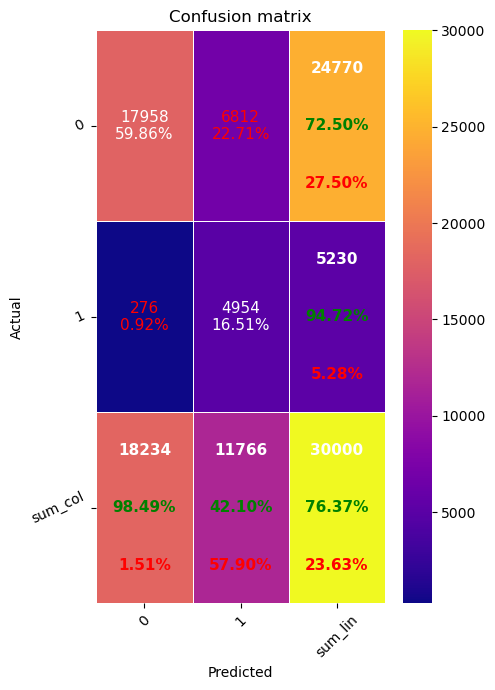


Threshold 0.499


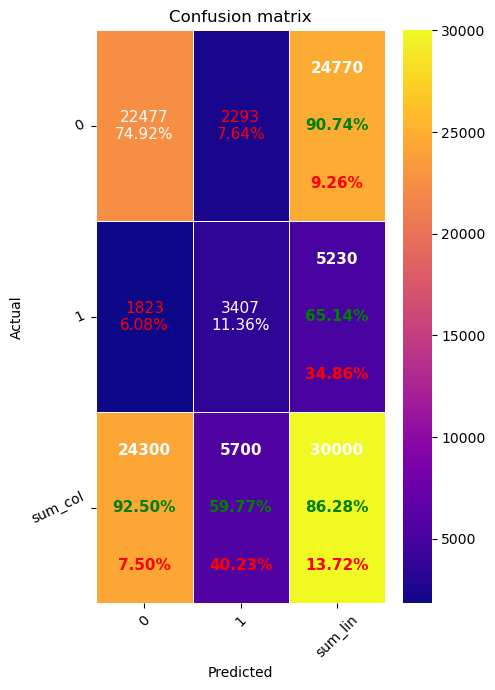


Threshold 0.5


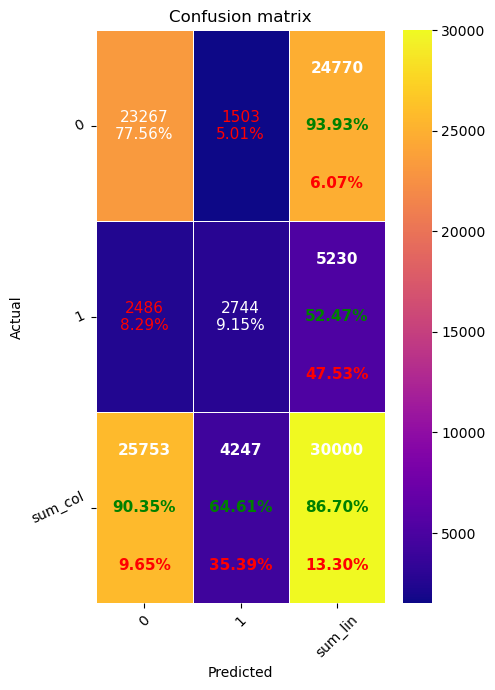


Threshold 0.501


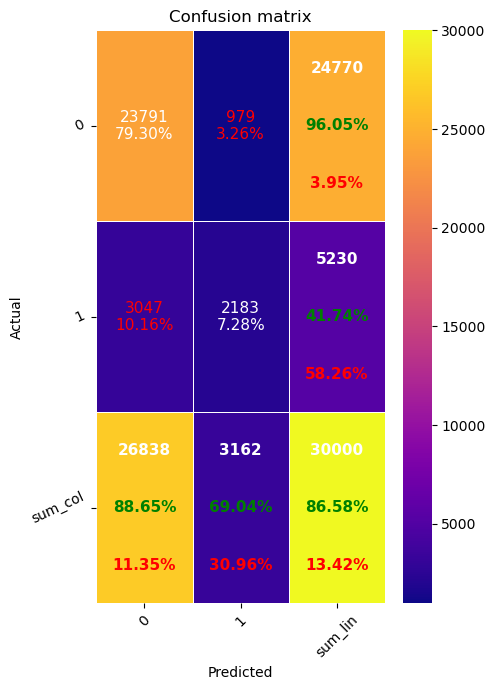


Threshold 0.505


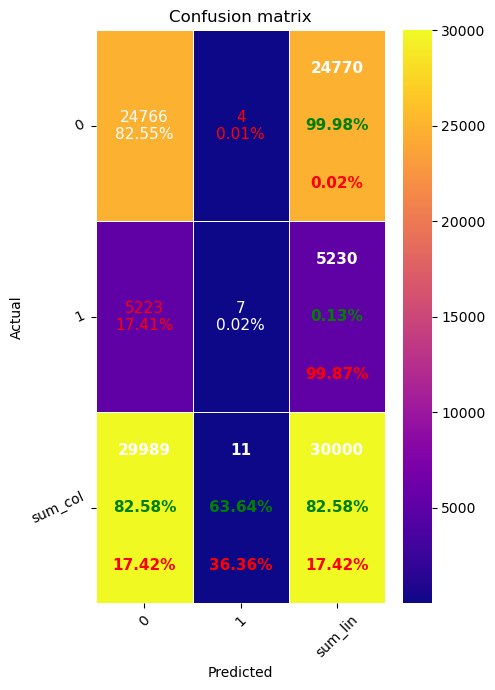


CPU times: user 42.8 s, sys: 3.38 s, total: 46.2 s
Wall time: 3min 42s


In [65]:
%%time
from sklearn.ensemble import AdaBoostClassifier
ada_boost_grid = {
    'n_estimators': [50, 75, 100, 150, 200],
    'learning_rate': [0.5, 1, 5, 10],
    'algorithm': ['SAMME', 'SAMME.R']
}

model = AdaBoostClassifier()
thresholds = [0.495, 0.499, 0.5, 0.501, 0.505]


ada_ans, ada_best, ada_cv = get_full_results(model, ada_boost_grid, thresholds, X_slice[features], X_slice[target], scoring_func='roc_auc', cv=3)

In [69]:
ada_cv.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 200}

In [71]:
ada_cv.best_score_

0.9138540389489554

In [66]:
ada_cv.cv_results_

{'mean_fit_time': array([ 8.70993225, 13.55921014, 19.09501775, 29.04476174, 36.50644326,
        10.74169819, 15.04521481, 17.44875201, 26.23509002, 35.95062359,
         7.73675791, 13.58146032, 18.68841807, 28.6494654 , 39.5868756 ,
         9.49679701, 14.77236986, 20.45377421, 29.48055394, 37.414704  ,
        11.15105661, 15.12123656, 18.57200352, 26.94334396, 36.33047167,
         8.44222832, 13.46993399, 19.16240843, 28.23183099, 39.61858495,
        10.12424461, 13.1792016 , 17.69555457, 31.76387676, 41.55134694,
        10.11865028, 18.02238162, 21.97129973, 26.97104247, 26.58068744]),
 'std_fit_time': array([0.26293614, 0.26125807, 0.59506536, 0.31814248, 0.72474935,
        1.04671962, 0.36932828, 0.13647525, 0.5957708 , 0.45795104,
        0.12335507, 0.19474723, 0.0784518 , 0.22706912, 0.27351108,
        0.29140321, 0.48132554, 0.18271353, 0.31219988, 0.30598941,
        0.19034736, 0.33513918, 0.30817245, 0.2886879 , 0.14689027,
        0.03222877, 0.08705679, 0.1651319

In [70]:
pd.DataFrame(ada_ans).T

,tn,fp,fn,tp,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0.495,0.598600,0.227067,0.009200,0.165133,0.763733,0.421044,0.947228,0.582961,0.836109
0.499,0.749233,0.076433,0.060767,0.113567,0.862800,0.597719,0.651434,0.623422,0.779431
0.500,0.775567,0.050100,0.082867,0.091467,0.867033,0.646103,0.524665,0.579086,0.731994
0.501,0.793033,0.032633,0.101567,0.072767,0.865800,0.690386,0.417400,0.520257,0.688938
0.505,0.825533,0.000133,0.174100,0.000233,0.825767,0.636364,0.001338,0.002671,0.500588


### CatBoost

In [111]:
%%time
from catboost import CatBoostClassifier
catboost_grid = {
    'iterations': [500, 1000],  # Количество итераций (чем больше, тем лучше, но дольше обучение)
    'depth': [4, 6, 10],  # Глубина дерева (больше глубина -> больше шансов переобучения)
    'learning_rate': [0.01, 0.1, 0.5],  # Скорость обучения (меньше значение -> медленнее обучение, но более точная модель)
    'l2_leaf_reg': [1, 5, 9],  # Коэффициент регуляризации по L2 (регуляризация листов дерева)
    'bagging_temperature': [0, 1, 5],  # Интенсивность использования bagging (0 - отключен, больше значение -> больше разнообразие моделей)
    'verbose': [0]
}

model = CatBoostClassifier()
thresholds = [0.45, 0.475, 0.5, 0.525, 0.55]

ans_cat_boost, cat_boost_best, cat_boost_cv = get_full_results(model, catboost_grid, thresholds, X_slice[features], X_slice[target], scoring_func='roc_auc')

Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 

In [ ]:
cat_boost_cv.best_params_

{'threshold_days': 60}

In [ ]:
cat_boost_cv.best_score_

0.8225000272101651

In [ ]:
cat_boost__cv.cv_results_

{'mean_fit_time': array([0.01701335, 0.01819376, 0.01448441, 0.01315892, 0.01062493,
        0.00846271, 0.00957414, 0.0091964 , 0.00824678, 0.00921786,
        0.00929983, 0.01116129]),
 'std_fit_time': array([0.00291777, 0.00222058, 0.00280736, 0.00382282, 0.00480111,
        0.00160172, 0.00227478, 0.00266468, 0.00185744, 0.00251399,
        0.00258994, 0.00370352]),
 'mean_score_time': array([0.25936739, 0.21166162, 0.20738538, 0.18724565, 0.11808117,
        0.11080134, 0.10994029, 0.11034513, 0.10648521, 0.1138521 ,
        0.11769688, 0.1378355 ]),
 'std_score_time': array([0.02174065, 0.03942845, 0.05956768, 0.02842009, 0.022608  ,
        0.00271531, 0.00562745, 0.00766317, 0.00569866, 0.00780821,
        0.0115364 , 0.01565782]),
 'param_threshold_days': masked_array(data=[5, 10, 15, 20, 30, 40, 60, 90, 120, 130, 140, 150],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
     

In [25]:
pd.DataFrame(ans_cat_boost).T

,tn,fp,fn,tp,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0.450,0.758333,0.063667,0.087667,0.090333,0.848667,0.586580,0.507491,0.544177,0.715019
0.475,0.765333,0.056667,0.093333,0.084667,0.850000,0.599057,0.475655,0.530271,0.703359
0.500,0.773667,0.048333,0.102000,0.076000,0.849667,0.611260,0.426966,0.502756,0.684083
0.525,0.779333,0.042667,0.107667,0.070333,0.849667,0.622419,0.395131,0.483391,0.671613
0.550,0.786333,0.035667,0.114000,0.064000,0.850333,0.642140,0.359551,0.460984,0.658080


### EasyModel

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin
class EasyModel2(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold_days=None):
        self.threshold_days = threshold_days
        self.classes_ = np.array([0, 1])

    def predict(self, X0):
        ans = list(apply_par_row_batches(X0, ['recency'], lambda x: 1.0 if int(x['recency'] * 673 + 1) > self.threshold_days else 0.0).values)
        return ans
    
    def fit(self, X, y):
        return self

    def get_params(self, deep=True):
        return {'threshold_days': self.threshold_days}
    
    def set_params(self, **params):
        for k, v in params.items():
            setattr(self, k, v)
        return self
    
    def predict_proba(self, X0):
        return np.array([[1 - p, p] for p in self.predict(X0)])
    
    def __str__(self):
        return f'EasyModel (threshold_days={self.threshold_days})'

Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/1 [00:00<?, ?it/s]

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
21026935    0.0
11081032    0.0
17906240    1.0
20110139    0.0
5394327     0.0
           ... 
4697650     0.0
16697161    0.0
20023411    0.0
9713686     0.0
8635977     0.0
Name: is_out, Length: 100, dtype: float64


Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/12 [00:00<?, ?it/s]
Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|

Processing func: EasyModel2.predict.<locals>.<lambda>:   0%|          | 0/30 [00:00<?, ?it/s]

Threshold 0.5


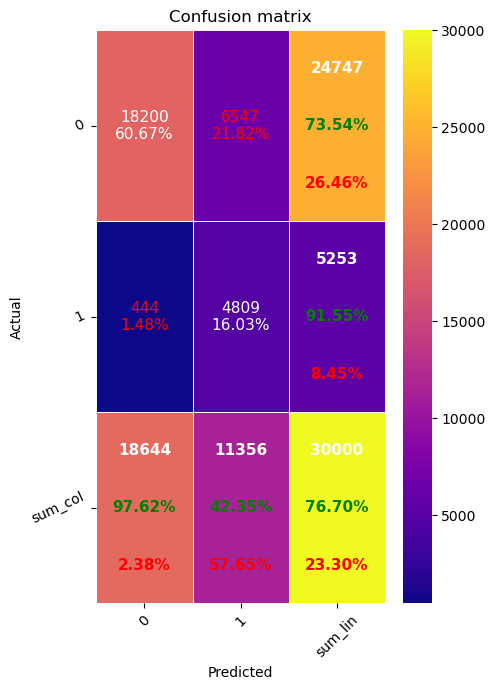

In [74]:
from sklearn.metrics import make_scorer, precision_score
grid = {'threshold_days': [5, 10, 15, 20, 30, 40, 60, 90, 120, 130, 140, 150]}

em = EasyModel2()
easy_res, easy_best, easy_cv = get_full_results(em, grid, [0.5], X_slice[features], X_slice[target], scoring_func='roc_auc', cv=6)

In [75]:
easy_cv.best_params_

{'threshold_days': 60}

In [76]:
easy_cv.best_score_

0.8225000272101651

In [77]:
easy_cv.cv_results_

{'mean_fit_time': array([0.01701335, 0.01819376, 0.01448441, 0.01315892, 0.01062493,
        0.00846271, 0.00957414, 0.0091964 , 0.00824678, 0.00921786,
        0.00929983, 0.01116129]),
 'std_fit_time': array([0.00291777, 0.00222058, 0.00280736, 0.00382282, 0.00480111,
        0.00160172, 0.00227478, 0.00266468, 0.00185744, 0.00251399,
        0.00258994, 0.00370352]),
 'mean_score_time': array([0.25936739, 0.21166162, 0.20738538, 0.18724565, 0.11808117,
        0.11080134, 0.10994029, 0.11034513, 0.10648521, 0.1138521 ,
        0.11769688, 0.1378355 ]),
 'std_score_time': array([0.02174065, 0.03942845, 0.05956768, 0.02842009, 0.022608  ,
        0.00271531, 0.00562745, 0.00766317, 0.00569866, 0.00780821,
        0.0115364 , 0.01565782]),
 'param_threshold_days': masked_array(data=[5, 10, 15, 20, 30, 40, 60, 90, 120, 130, 140, 150],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
     

### Визуализация кросс-валидации

In [123]:
precision_score.__name__

'precision_score'

In [127]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
a = [(f'{i.__name__}', []) for i in metrics] + [(i, []) for i in ['tp', 'fp', 'tn', 'fn']]
ans_all = dict(a)
ans_all

{'accuracy_score': [],
 'precision_score': [],
 'recall_score': [],
 'f1_score': [],
 'roc_auc_score': [],
 'tp': [],
 'fp': [],
 'tn': [],
 'fn': []}

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cv_results(easy_cv):
    params, scores, scores_std = easy_cv.__dict__['cv_results_']['params'], easy_cv.__dict__['cv_results_']['mean_test_score'], easy_cv.__dict__['cv_results_']['std_test_score']
    param_names = list(params[0].keys())

    fig, axs = plt.subplots(len(param_names), 1, figsize=(10, 7))
    if len(param_names) == 1:
        axs = [axs]
    else:
        axs = axs.flat
    for i, ax in enumerate(axs):
        param_name = param_names[i]
        params_ = [i[param_name] for i in params]
        ax.scatter(params_, scores, color='b')
        ax.fill_between(params_, scores - scores_std, scores + scores_std, alpha=0.3, color='r')
        ax.set_xlabel(f'Params ({param_name})')
        ax.set_ylabel('Score')
    fig.tight_layout()


def plot_threshold_metrics(y_true, y_pred_proba, left=0.05, right=1.0):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    thresholds = np.arange(left, right, 0.01)
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]

    def get_data():
        ans_all = dict([(f'{i.__name__}', []) for i in metrics] + [(i, []) for i in ['tp', 'fp', 'tn', 'fn']])

        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            cm = confusion_matrix(y_true, y_pred)
            tn, fp, fn, tp = [i / sum(cm.ravel()) for i in cm.ravel()]
            ans_all['tn'].append(tn)
            ans_all['fp'].append(fp)
            ans_all['fn'].append(fn)
            ans_all['tp'].append(tp)

            for metric in metrics:
                ans_all[metric.__name__].append(metric(y_true, y_pred))
        return ans_all

    ans = get_data()

    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    for metric in metrics:
        axs[0].plot(thresholds, ans[metric.__name__], label=f'{metric.__name__}')

    axs[0].set_xlabel('Thresholds')
    axs[0].set_ylabel('Metric values')
    axs[0].set_xticks(np.arange(left, right, 0.05))
    axs[0].set_yticks(np.arange(0, 1, 0.05))
    axs[0].grid(visible=True)
    axs[0].legend()

    for t in ['tp', 'fp', 'tn', 'fn']:
        axs[1].plot(thresholds, ans[t], label=f'{t} normalized')
    
    axs[1].set_xlabel('Thresholds')
    axs[1].set_ylabel('Normalized counts')
    axs[1].set_xticks(np.arange(left, right, 0.05))
    axs[1].set_yticks(np.arange(0, 1, 0.05))
    axs[1].grid(visible=True)
    axs[1].legend()

    fig.tight_layout()

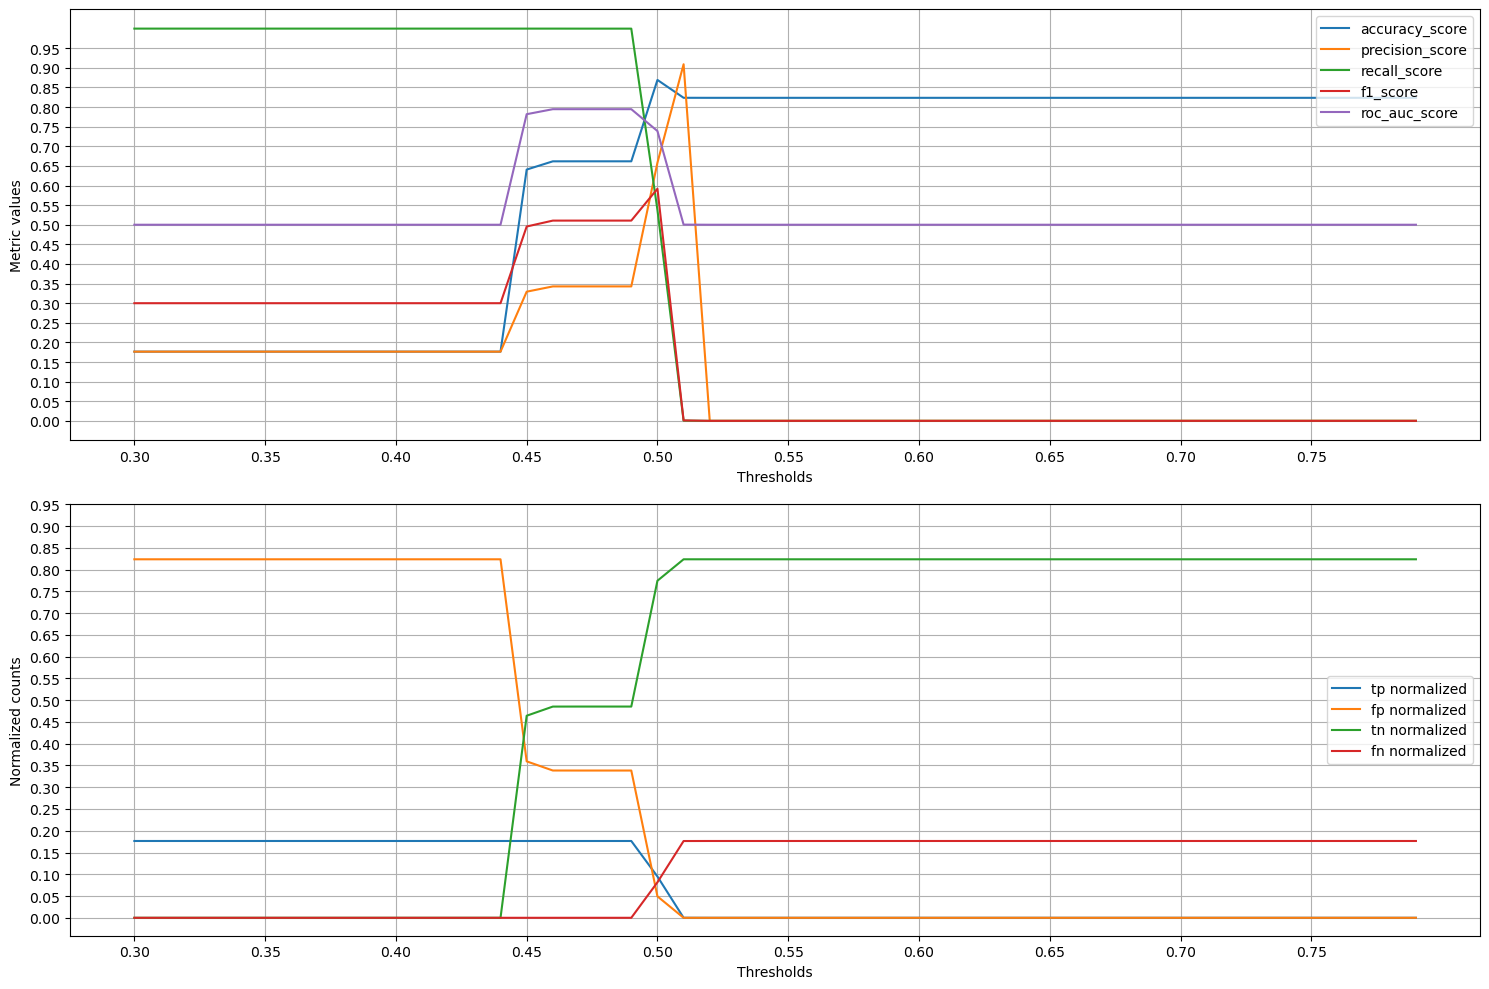

In [151]:
plot_threshold_metrics(X_slice[target], ada_best.predict_proba(X_slice[features])[:, 1], left=0.3, right=0.8)

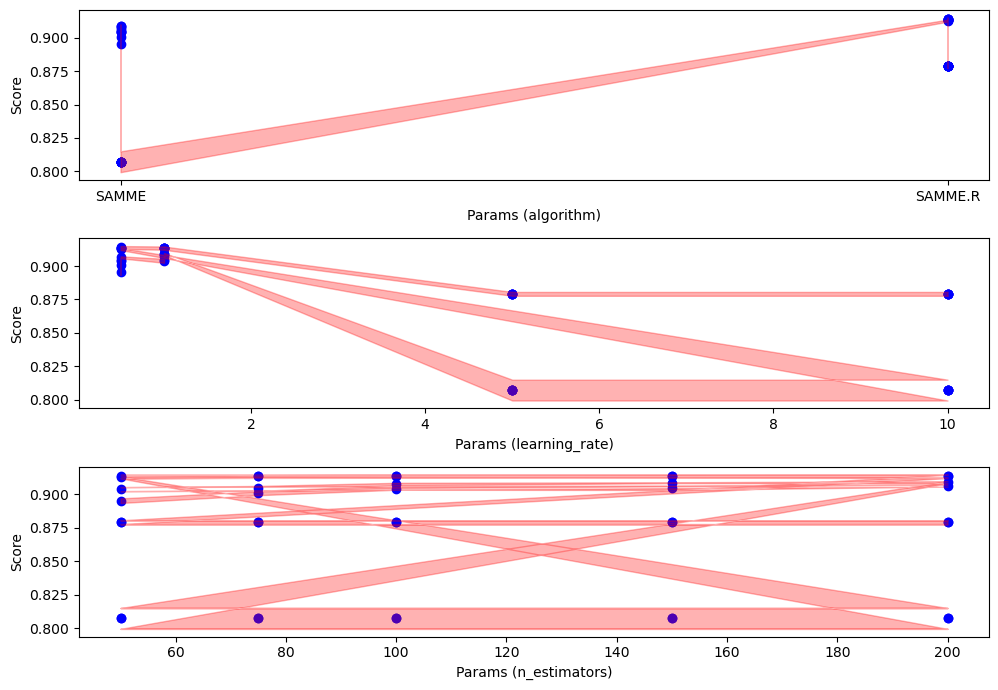

In [107]:
plot_cv_results()

In [14]:
best


AdaBoostClassifier(algorithm='SAMME', learning_rate=5)

In [15]:
pd.DataFrame(ans_ada_boost).T

,tn,fp,fn,tp,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0.20,0.000333,0.821,0.000333,0.178333,0.178667,0.178452,0.998134,0.302773,0.499270
0.30,0.000333,0.821,0.000333,0.178333,0.178667,0.178452,0.998134,0.302773,0.499270
0.40,0.000333,0.821,0.000333,0.178333,0.178667,0.178452,0.998134,0.302773,0.499270
0.45,0.000333,0.821,0.000333,0.178333,0.178667,0.178452,0.998134,0.302773,0.499270
0.50,0.703333,0.118,0.061000,0.117667,0.821000,0.499293,0.658582,0.567981,0.757457
0.55,0.821333,0.000,0.178667,0.000000,0.821333,0.000000,0.000000,0.000000,0.500000
0.60,0.821333,0.000,0.178667,0.000000,0.821333,0.000000,0.000000,0.000000,0.500000
0.70,0.821333,0.000,0.178667,0.000000,0.821333,0.000000,0.000000,0.000000,0.500000
0.80,0.821333,0.000,0.178667,0.000000,0.821333,0.000000,0.000000,0.000000,0.500000


In [43]:
from sklearn import model_selection
from tqdm.notebook import tqdm
class TqdmCallback:
    def __init__(self, n_iter):
        self.progress_bar = tqdm(total=n_iter, desc="Grid Search Progress")
    
    def __call__(self, *args, **kwargs):
        self.progress_bar.update(1)


X, y = X_slice[features], X_slice[target]

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
n_splits = 5

# Создаем экземпляр класса для отслеживания прогресса
callback = TqdmCallback(n_iter=len(param_grid['C']) * len(param_grid['kernel']) * n_splits)

# Создаем GridSearchCV
grid_search = model_selection.GridSearchCV(SVC(), param_grid, cv=n_splits, n_jobs=-1)

# Выполняем Grid Search с прогресс-баром
grid_search.fit(X, y, callback=callback)

# Закрываем прогресс-бар после завершения
callback.progress_bar.close()

Grid Search Progress:   0%|          | 0/30 [00:00<?, ?it/s]

PicklingError: Could not pickle the task to send it to the workers.

## Посмотреть на четность покупок по gmv (клиент закупаем товары, затем приходит за забытыми один раз или наоборот)